In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from scipy.stats import ttest_ind
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression



Experiment and metrics design - Gotham and Metropolis



1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

Assuming that currently drivers accept rides mostly in their home area. The key indicator could be the number 
of rides taken outside of their home city. I choose this because it is a direct mesaurment that the driver
was available and completed the job. 


2) Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
    
    a) how you will implement the experiment
    
    b) what statistical test(s) you will conduct to verify the significance of the
        observation
        
    c) how you would interpret the results and provide recommendations to the city
        operations team along with any caveats.
        
        
I would examine the current percentage of rides a paticular driver accepted and completed outside of their home
city. 

After collecting baseline data we could implement the toll refund to collect our testing set. Collecting data for the
testing period, we would be able to determine an increase in the percentage of rides taken in both target areas by
drivers. We could then conduct statistical significance tests including t and p tests to determine how probable 
our results and how effective they may be.


In [2]:
df = pd.read_json('ultimate_data_challenge.json')

In [3]:
df.info()

df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Da

In [4]:
# Our active group is last trip w/in 30 days, o how did those ppl start

currActive = df.loc[df['last_trip_date'] >= '2014-06-01' ]

currActive.value_counts()

city            trips_in_first_30_days  signup_date  avg_rating_of_driver  avg_surge  last_trip_date  phone    surge_pct  ultimate_black_user  weekday_pct  avg_dist  avg_rating_by_driver
Astapor         0                       2014-01-01   3.0                   1.00       2014-06-01      Android  0.0        True                 80.0         4.82      4.8                     1
Winterfell      1                       2014-01-05   4.4                   1.03       2014-06-29      iPhone   6.1        True                 63.6         2.34      4.5                     1
                                                     3.8                   1.08       2014-06-18      Android  16.7       False                83.3         2.33      4.3                     1
                                                     4.0                   1.00       2014-06-09      Android  0.0        False                33.3         8.17      5.0                     1
                                             

<AxesSubplot:xlabel='last_trip_date'>

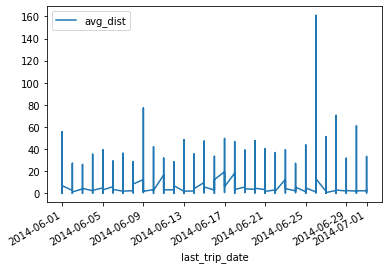

In [5]:
currActive.plot(x='last_trip_date', y='avg_dist')

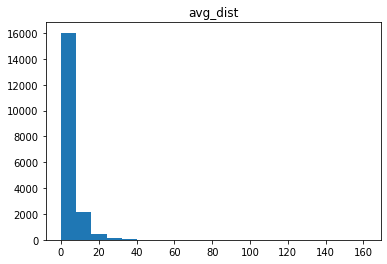

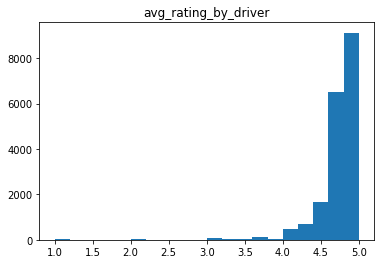

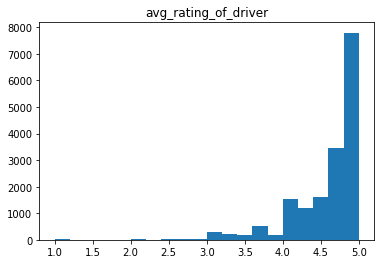

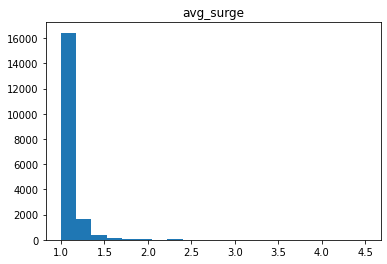

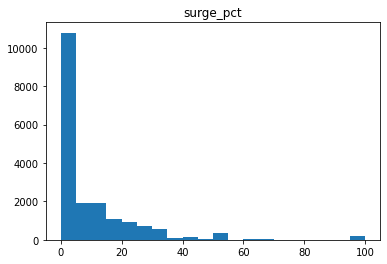

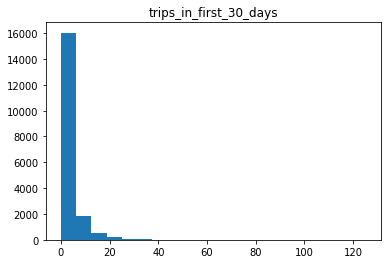

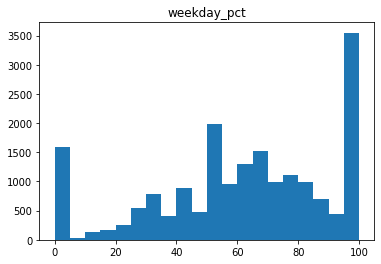

In [6]:
# now look for weekday patters and see if you can increase the weekday trips.
# are there more weekday trips than weekend?
# what section has the higest weekday pct?

xCols = ["avg_dist", "avg_rating_by_driver","avg_rating_of_driver", "avg_surge", "surge_pct", "trips_in_first_30_days", "weekday_pct"]

for col in xCols:
    plt.hist(currActive[col], bins=20)
    plt.title(col)
    plt.show()

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


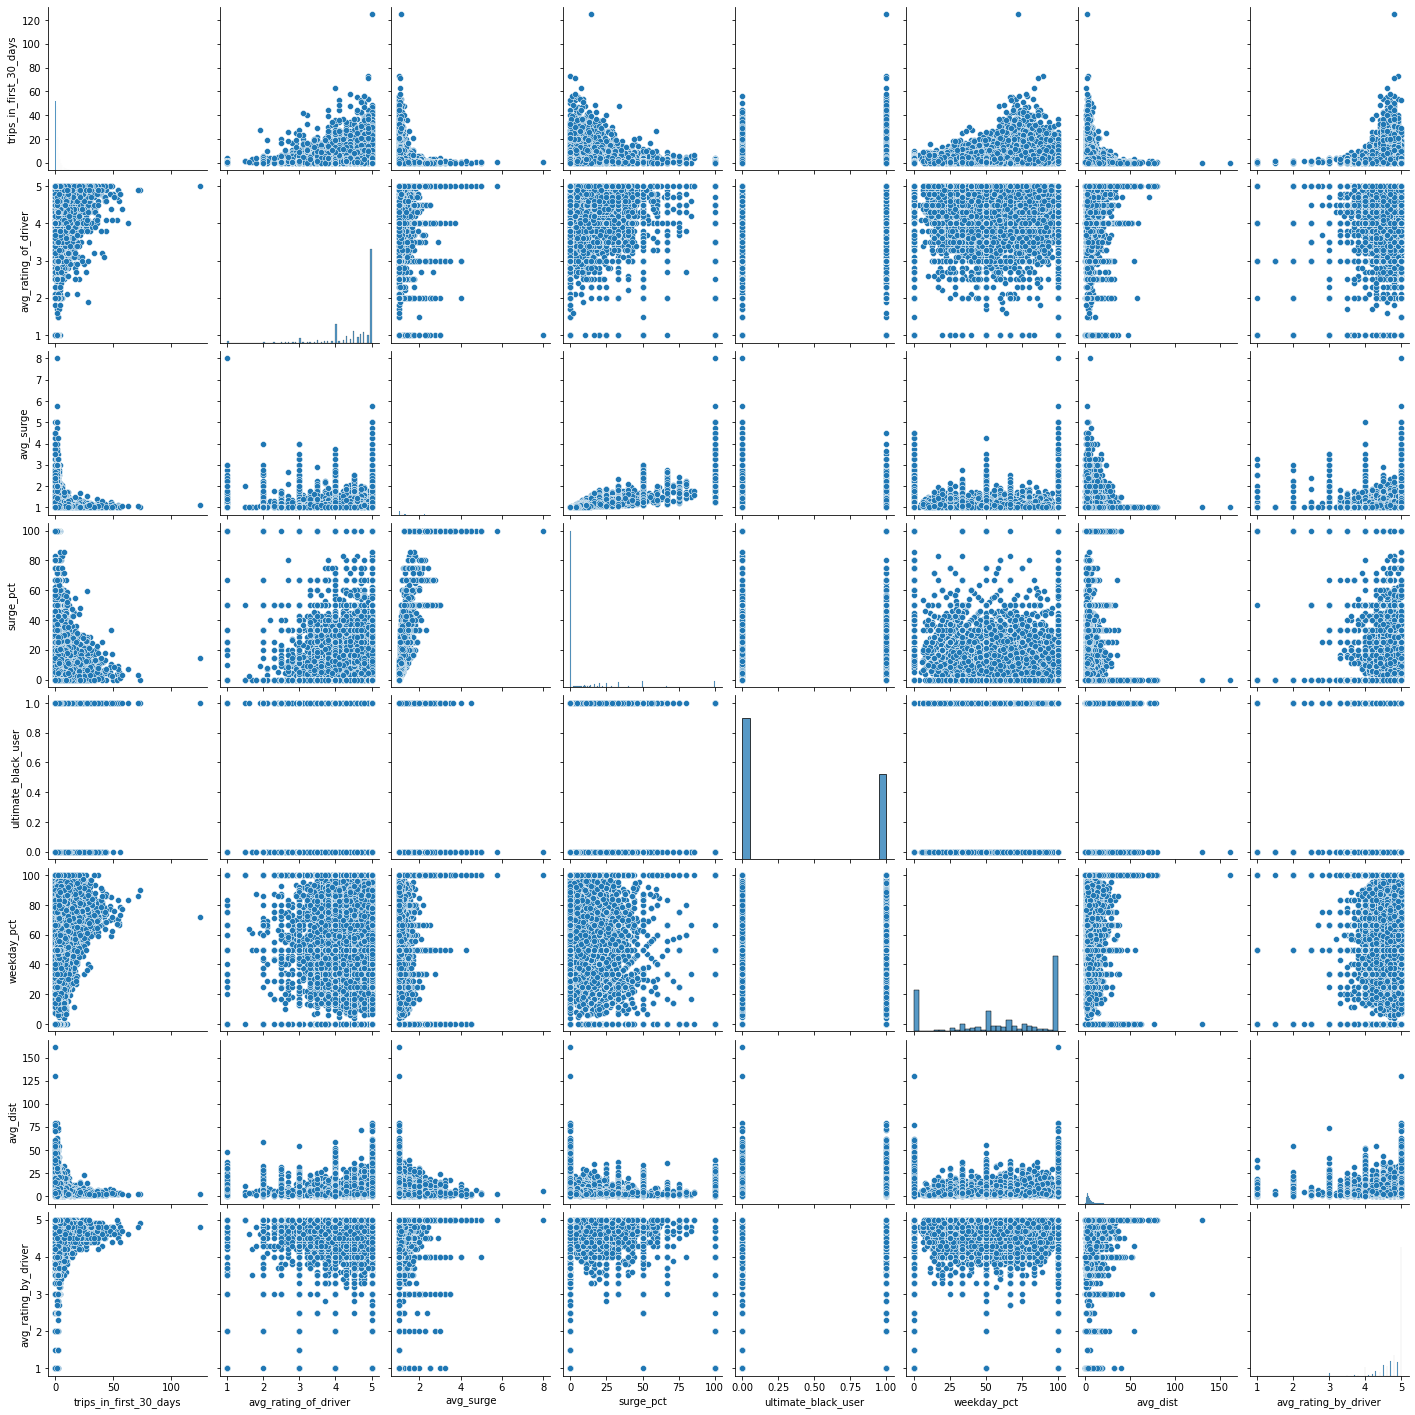

In [7]:
sns.pairplot(df)

<AxesSubplot:xlabel='weekday_pct', ylabel='trips_in_first_30_days'>

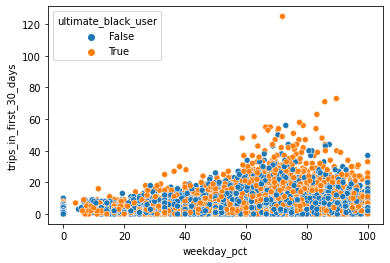

In [8]:
sns.scatterplot(data=df, x= 'weekday_pct', y='trips_in_first_30_days', hue='ultimate_black_user')

In [9]:
print('{}% of users were retained in the 6th month'.format(len(currActive)/len(df)))


0.37608% of users were retained in the 6th month


In [10]:
df['active'] = df['last_trip_date']>=('2014-06-01')
df['active'] = df['active'].astype('int')
df.phone.value_counts()
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [11]:
df.fillna({'avg_rating_by_driver':df['avg_rating_by_driver'].mean()}, inplace=True)
df.fillna({'avg_rating_of_driver':df['avg_rating_of_driver'].mean()}, inplace=True)
df['ultimate_black_user'] = df['ultimate_black_user'].astype('int')
df['active'] = df['active'].astype('int')
#df.dropna(how='any', inplace=True)

df.fillna({'phone':0}, inplace=True)

df.isnull().sum()
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,0


In [12]:
#dfOneHot = scaledDf.drop(["city", "phone", "ultimate_black_user", "last_trip_date", "signup_date"], axis=1)

#X = dfOneHot.drop('active', axis=1)
#y = dfOneHot[['active']]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [13]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,0


In [14]:
df['phoneType'] = 0
df['phoneType'] = pd.get_dummies(df['phone'], drop_first=True)
#df.drop('phone', axis=1, inplace=True)


df['location'] = 0
df['location'] = pd.get_dummies(df['city'], drop_first=True)
#df.drop('city', axis=1, inplace=True)

df.head()



,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,phoneType,location
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,1,0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,0,1,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,0,0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,1,0,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,0,1,0


In [15]:
target = df['active']
df.drop('active', axis=1, inplace=True)
df.drop('phone', axis=1, inplace=True)
df.drop('city', axis=1, inplace=True)



In [16]:
####Adapt for below

from sklearn.preprocessing import scale


df.drop(['last_trip_date', 'signup_date'], axis=1, inplace=True)

scaledDf = pd.DataFrame(scale(df))
scaledDf.columns = df.columns
scaledDf.head()


X_train, X_test, y_train, y_test = train_test_split(scaledDf, target, random_state=13)


In [17]:
# Evaluate model using test sets

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

#dfOneHot['active'] = dfOneHot['active'].astype('int')

logreg = LogisticRegression(C=0.001, penalty='l2', random_state=13)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)


print('Accuracy of test set was {}\n'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()


print('True Negative : {}\tFalse Positive = {}\nFalse Negative : {}\tTrue Positive : {}'
     .format(tn,fp,fn,tp))

Accuracy of test set was 0.71872

              precision    recall  f1-score   support

           0       0.73      0.87      0.80      7802
           1       0.69      0.46      0.55      4698

    accuracy                           0.72     12500
   macro avg       0.71      0.67      0.67     12500
weighted avg       0.71      0.72      0.70     12500

True Negative : 6822	False Positive = 980
False Negative : 2536	True Positive : 2162


(array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

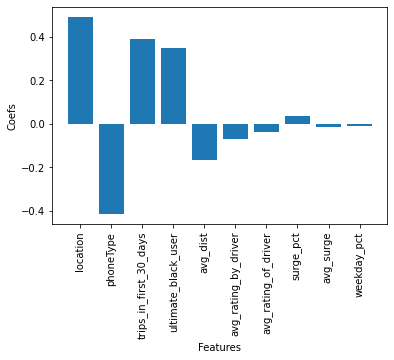

In [18]:
#scaledDf.drop('active', axis=1, inplace=True)
# Extract coefficients
coefs = pd.Series(logreg.coef_.reshape(-1), index=df.columns)



coefs = coefs[coefs.abs().sort_values(ascending=False).index]

plt.bar(range(len(coefs)), coefs)
plt.xticks(range(len(coefs)), coefs.index, rotation=90)
plt.xlabel('Features')
plt.ylabel('Coefs')
plt.xticks()
plt.yticks()